# [Projet 6: Catégorisez automatiquement des questions](https://openclassrooms.com/fr/projects/categorisez-automatiquement-des-questions)
(parcours data: [here](https://openclassrooms.com/paths/63-data-scientist))

## Data cleaning

Data exporter (StackExchange): [here](https://data.stackexchange.com/stackoverflow/query/new).  
My minimal SQL query:
```
SELECT
   Id,Body,Title,Tags
FROM
   Posts
WHERE
   Id < 5000 and Body<>'' and Title<>'' and Tags <>''
```

Resources:
- [tutorial on kaggle](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words) (I did this basically on my own, but look at the features with scikit-learn section)

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(HOME+'Documents/GitHub/OCDataSciencePath/Project6/Work/')    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import pandas as pd
from scipy.sparse import hstack

import matplotlib.pyplot as plt
%matplotlib inline

Some info and uses for [BeautifulSoup](https://pypi.org/project/beautifulsoup4/): [here](https://www.pythonforbeginners.com/beautifulsoup/beautifulsoup-4-python),

In [2]:
from bs4 import BeautifulSoup # conda install beautifulsoup4

Some info and uses for [NLTK](https://pypi.org/project/nltk/): [here](http://www.nltk.org/book/),

In [3]:
import nltk
#nltk.download('punkt')

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [5]:
from Pkg.helper import basicHTMLTextCleaner, basicTagTextCleaner, isValidData # needs correct working directory

### Data

In [6]:
if HOST == 'Arthurs-MacBook-Pro.local':
    pathToDataDir = HOME+'Documents/Dropbox/Transit/OCDataScienceData/Project6/'    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))

In [7]:
filename = 'QueryResults_light.csv'
filename = 'QueryResults_10k.csv'

df = pd.read_csv(pathToDataDir+filename,index_col='Id')

In [8]:
n,p = df.shape
k = .8
df_train,df_test = df.iloc[:int(k*n),:].copy(),df.iloc[int(k*n):,:].copy()

In [9]:
print(df_train.shape,df_test.shape)
df_train.sample(5)

(9028, 3) (2258, 3)


,Body,Title,Tags
Id,,,
64992,<p>I'm working with a support person who is su...,Why is access denied when installing SSL cert ...,<ssl><permissions><iis-5><windows-server-2000>
44644,<p>At my day job we have load balanced web ser...,Identifying ASP.NET web service references,<web-services><iis><reflection><esb>
25200,<p>I don't like the AutoSize property of the L...,C#.NET Winforms: Is it possible to override La...,<c#><winforms>
15735,"<p>Does anyone know of a firefox extension, or...",Firefox extension for website interaction reco...,<firefox><testing>
41027,<p>I am looking for a little bit of JQuery or ...,What's a good bit of JS or JQuery for horizont...,<javascript><jquery><scroll><client-scripting>


### Basic text cleaning

In [10]:
def applyCleaner(df,tokenizer,stopwords,stemer):
    '''
    applies the cleaner to a pd.DataFrame. See called functions for help.
    '''
    for c in ('Body','Title'):
        df[c+'_clean'] = df[c].apply(lambda x: basicHTMLTextCleaner(x,tokenizer,stopwords,stemer))
    for c in ('Tags',):
        df[c+'_clean'] = df[c].apply(lambda x: basicTagTextCleaner(x))
        
    return df

In [11]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemer = nltk.PorterStemmer()

df_train = applyCleaner(df_train,tokenizer,stopwords,stemer)
df_test = applyCleaner(df_test,tokenizer,stopwords,stemer)

In [12]:
df_train.sample(50)

,Body,Title,Tags,Body_clean,Title_clean,Tags_clean
Id,,,,,,
75777,<p>I assumed that the C# margin property had a...,What is the .NET Control.Margin property for?,<c#><controls><margin>,assum c margin properti mean like css space ar...,net control margin properti,<c#><controls><margin>
25653,<p>Is there any way to apply an attribute to a...,Hide a column in ASP.NET Dynamic Data,<asp.net><dynamic-data>,way appli attribut model file asp net dynam da...,hide column asp net dynam data,<asp.net><dynamic-data>
73029,<p>I try to use the Forms-Based authentication...,Embedded Jetty serving static content with for...,<java><web-applications><jetty>,tri use form base authent within embed jetti 6...,embed jetti serv static content form authent,<java><web-applications><jetty>
77193,<p>You've just written a pile of code to deliv...,How do you justify Refactoring work to your pe...,<refactoring>,written pile code deliv import featur pressur ...,justifi refactor work penni pinch boss,<refactoring>
42550,<p>I need to take a web page and extract the a...,Extract Address Information from a Web Page,<vb.net><screen-scraping><street-address>,need take web page extract address inform page...,extract address inform web page,<vb.net><screen-scraping><street-address>
70816,<p>Is it possible to use the Asp.Net MVC frame...,Using Asp.Net MVC with SharePoint,<asp.net-mvc><sharepoint>,possibl use asp net mvc framework within share...,use asp net mvc sharepoint,<asp.net-mvc><sharepoint>
13545,<p>I recently (a few days ago) installed .NET ...,.NET 3.5 SP1 and aspnet_client Crystal Reports,<.net><asp.net><.net-3.5><crystal-reports>,recent day ago instal net 3 5 sp1 subsequ aspn...,net 3 5 sp1 aspnet_cli crystal report,<.net><asp.net><.net-3.5><crystal-reports>
22943,<p>I have the need to read the Thunderbird add...,Does anybody know of existing code to read a m...,<.net><file-format><thunderbird><mork>,need read thunderbird address book fli store f...,anybodi know exist code read mork file thunder...,<.net><file-format><thunderbird><mork>
15649,"<p>The Gang of Four's <a href=""http://en.wikip...",Can you really build a fast word processor wit...,<java><performance><design-patterns><ide><text...,gang four design pattern use word processor ex...,realli build fast word processor gof design pa...,<java><performance><design-patterns><ide><text...


### Vectorization

Resources
- [scikit tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) (also used in this [kaggle example](https://www.kaggle.com/c/word2vec-nlp-tutorial#part-1-for-beginners-bag-of-words))

*Input texts:*

In [13]:
# count occurences (beware to fit the dictionary only on train data!)
# NB: deal with tags separately, as they basically need one-hot encoding
V_body = 20 # 500
count_body = CountVectorizer(analyzer = "word",   # entities to be counted
                             preprocessor = None, # because we did it ourselves
                             lowercase = False,   # because we did it ourselves
                             stop_words = None,   # because we did it ourselves
                             tokenizer = None,    # because we did it ourselves
                             max_features = V_body) 

count_body.fit(df_train['Body_clean'])
vocab_body = count_body.vocabulary_

V_title = 5 # 100
count_title = CountVectorizer(analyzer = "word",   # entities to be counted
                              preprocessor = None, # because we did it ourselves
                              lowercase = False,   # because we did it ourselves
                              stop_words = None,   # because we did it ourselves
                              tokenizer = None,    # because we did it ourselves
                              max_features = V_title) 

count_title.fit(df_train['Title_clean'])
vocab_title = count_title.vocabulary_

# transform to vectors using the fitted dictionaries
body_train = count_body.transform(df_train['Body_clean'])
title_train = count_title.transform(df_train['Title_clean'])

body_test = count_body.transform(df_test['Body_clean'])
title_test = count_title.transform(df_test['Title_clean'])

In [14]:
# use TF-IDF (beware to fit the IDF with train data!)
tfidf_body = TfidfTransformer(use_idf=True).fit(body_train)
tfidf_title = TfidfTransformer(use_idf=True).fit(title_train)

# transform using the fitted IDF
body2_train = tfidf_body.transform(body_train)
title2_train = tfidf_title.transform(title_train)

body2_test = tfidf_body.transform(body_test)
title2_test = tfidf_title.transform(title_test)

In [15]:
body2_train[0,:].toarray()

array([[ 0.29301261,  0.        ,  0.53408227,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.30424963,
         0.        ,  0.        ,  0.        ,  0.28949523,  0.34987084,
         0.        ,  0.27233687,  0.        ,  0.50591248,  0.        ]])

In [16]:
title2_train[0,:].toarray()

array([[ 0.,  0.,  0.,  0.,  0.]])

*Target tags:*

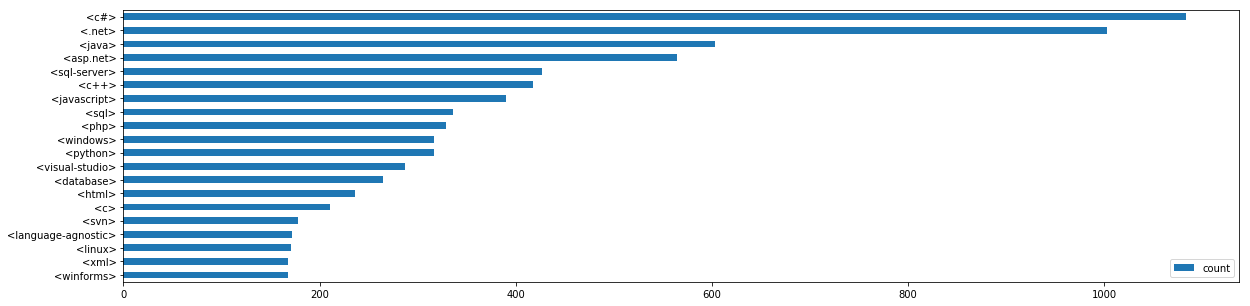

In [17]:
# analysis of the tags (NB: here we only 'multiplly'-one-hot encode: there is no need to compute TF-IDF!)

# count occurences
V_tag = 20 # NB (after viewing the plots): a looot of tags appear only once
count_tag = CountVectorizer(analyzer = "word",   # entities to be counted
                            preprocessor = None, # because we did it ourselves
                            lowercase = False,   # because we did it ourselves
                            stop_words = None,   # because we did it ourselves
                            tokenizer = None,    # because we did it ourselves
                            token_pattern = '<[^[<>]*>', # otherwise, treats tags as words
                            max_features = V_tag) 

count_tag.fit(df_train['Tags_clean'])
vocab_tag = count_tag.vocabulary_

# transform
tag_train = count_tag.transform(df_train['Tags_clean'])
tag_test = count_tag.transform(df_test['Tags_clean'])

# plot number of questions per tag
tagCount = pd.DataFrame(index=['count'])
for t,i in vocab_tag.items():
    tagCount[t] = tag_train[:,i].sum()
tagCount = tagCount.transpose()
tagCount = tagCount.sort_values(by='count',ascending=True)
tagCount.plot(kind='barh',figsize=(20,5))

In [18]:
tag_train[0,:].toarray()

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

*Merge together:*

In [19]:
x_train = hstack((body2_train,title2_train)) # need hstack because we work on sparse matrices...
x_test = hstack((body2_test,title2_test))

y_train = tag_train
y_test = tag_test

*Handle cases when some rows do not have selected words/tags...*

In [21]:
# SEE HOW TO AVOID THAT: go back to full matrices for subscripting, export...
x_train = x_train.toarray()
x_test = x_test.toarray()

y_train = y_train.toarray()
y_test = y_test.toarray()

In [22]:
isValid_train = isValidData(x_train,y_train,V_body)
isValid_test = isValidData(x_test,y_test,V_body)

x_train,y_train = x_train[isValid_train,:],y_train[isValid_train,:]
x_test,y_test = x_test[isValid_test,:],y_test[isValid_test,:]

In [23]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(1799, 25) (1799, 20)
(436, 25) (436, 20)


### Cleaned data

In [24]:
name,ext = os.path.splitext(filename)

#c = ('Body_clean','Title_clean','Tags_clean')
#df.loc[:,c].to_csv(os.path.join(pathToDataDir,name+'_clean'+ext),index=True)

np.savez(os.path.join(pathToDataDir,name+'_forLearning'), *[x_train,x_test,y_train,y_test])